<a href="https://colab.research.google.com/github/MoMedhat10/deep-learning-project/blob/main/carClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip DATA.zip

Archive:  DATA.zip
   creating: DATA/
   creating: DATA/bmw serie 1/
  inflating: DATA/bmw serie 1/back0.jpg  
  inflating: DATA/bmw serie 1/back1.jpg  
  inflating: DATA/bmw serie 1/back10.jpg  
  inflating: DATA/bmw serie 1/back11.jpg  
  inflating: DATA/bmw serie 1/back12.jpg  
  inflating: DATA/bmw serie 1/back13.jpg  
  inflating: DATA/bmw serie 1/back14.jpg  
  inflating: DATA/bmw serie 1/back15.jpg  
  inflating: DATA/bmw serie 1/back16.jpg  
  inflating: DATA/bmw serie 1/back17.jpg  
  inflating: DATA/bmw serie 1/back18.jpg  
  inflating: DATA/bmw serie 1/back19.jpg  
  inflating: DATA/bmw serie 1/back2.jpg  
  inflating: DATA/bmw serie 1/back20.jpg  
  inflating: DATA/bmw serie 1/back21.jpg  
  inflating: DATA/bmw serie 1/back22.jpg  
  inflating: DATA/bmw serie 1/back23.jpg  
  inflating: DATA/bmw serie 1/back24.jpg  
  inflating: DATA/bmw serie 1/back25.jpg  
  inflating: DATA/bmw serie 1/back26.jpg  
  inflating: DATA/bmw serie 1/back27.jpg  
  inflating: DATA/bmw serie 1/b

In [ ]:
!ls /content/DATA


'bmw serie 1'	    Golf	     'mercedes class a'   sandero
'chevrolet spark'  'hyundai i10'     'nemo citroen'	 'seat ibiza'
'chevroulet aveo'  'hyundai tucson'   octavia		  symbol
 clio		    logan	      picanto		 'toyota corolla'
 duster		    megane	      polo		 'volkswagen tiguan'


In [ ]:
!rm -rf /content/data


In [ ]:
import os
import shutil
import random

source_dir = "/content/DATA"
base_dir = "/content/data"

splits = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15
}

os.makedirs(base_dir, exist_ok=True)

for split in splits:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    n = len(images)
    train_end = int(splits["train"] * n)
    val_end = train_end + int(splits["val"] * n)

    split_files = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in split_files.items():
        split_class_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for file in files:
            shutil.copy(
                os.path.join(class_path, file),
                os.path.join(split_class_dir, file)
            )

print("✅ Dataset split completed successfully")


✅ Dataset split completed successfully


In [ ]:
!ls /content/data


test  train  val


In [ ]:
!ls /content/data/train


'bmw serie 1'	    Golf	     'mercedes class a'   sandero
'chevrolet spark'  'hyundai i10'     'nemo citroen'	 'seat ibiza'
'chevroulet aveo'  'hyundai tucson'   octavia		  symbol
 clio		    logan	      picanto		 'toyota corolla'
 duster		    megane	      polo		 'volkswagen tiguan'


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("/content/data/val", transform=val_transform)
test_dataset  = datasets.ImageFolder("/content/data/test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_dataset.classes)
print("num of classes", num_classes)


num of classes 20


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


ResNet **Training**

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.resnet50(pretrained=True)

# freeze layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


**Training Loop**

In [ ]:
from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.4f}")


100%|██████████| 71/71 [00:12<00:00,  5.58it/s]


Epoch 1: Train Accuracy = 0.1293


100%|██████████| 71/71 [00:11<00:00,  6.30it/s]


Epoch 2: Train Accuracy = 0.1740


100%|██████████| 71/71 [00:11<00:00,  6.23it/s]


Epoch 3: Train Accuracy = 0.2254


100%|██████████| 71/71 [00:11<00:00,  6.17it/s]


Epoch 4: Train Accuracy = 0.2724


100%|██████████| 71/71 [00:11<00:00,  6.19it/s]


Epoch 5: Train Accuracy = 0.3220


100%|██████████| 71/71 [00:11<00:00,  6.19it/s]


Epoch 6: Train Accuracy = 0.3503


100%|██████████| 71/71 [00:11<00:00,  6.16it/s]


Epoch 7: Train Accuracy = 0.3888


100%|██████████| 71/71 [00:11<00:00,  6.12it/s]


Epoch 8: Train Accuracy = 0.3986


100%|██████████| 71/71 [00:11<00:00,  6.11it/s]


Epoch 9: Train Accuracy = 0.4176


100%|██████████| 71/71 [00:11<00:00,  6.09it/s]

Epoch 10: Train Accuracy = 0.4349


**Test Set**

Test Accuracy: 0.49899799599198397


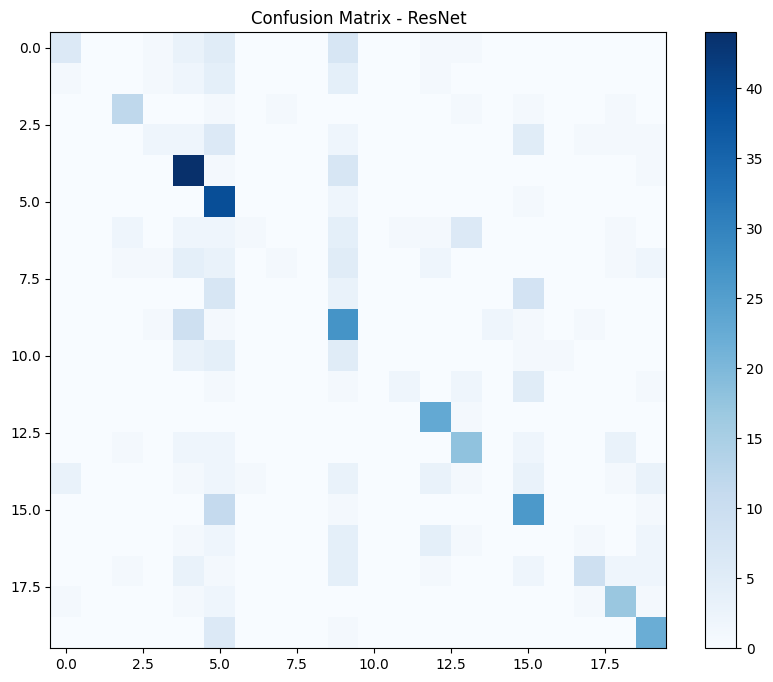

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print("Test Accuracy:", acc)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - ResNet")
plt.colorbar()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

class_names = test_loader.dataset.classes

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Precision: 0.4411572095000242
Recall: 0.49899799599198397
F1 Score: 0.4245520160925132

Classification Report:

                   precision    recall  f1-score   support

             Golf       0.55      0.25      0.34        24
      bmw serie 1       0.00      0.00      0.00        13
  chevrolet spark       0.71      0.71      0.71        17
  chevroulet aveo       0.33      0.10      0.15        20
             clio       0.57      0.83      0.68        53
           duster       0.39      0.93      0.55        42
      hyundai i10       0.50      0.05      0.09        20
   hyundai tucson       0.50      0.05      0.09        20
            logan       0.00      0.00      0.00        18
           megane       0.34      0.64      0.44        42
 mercedes class a       0.00      0.00      0.00        14
     nemo citroen       0.67      0.17      0.27        12
          octavia       0.64      0.96      0.77        24
          picanto       0.58      0.64      0.61        28
  

**ROC**

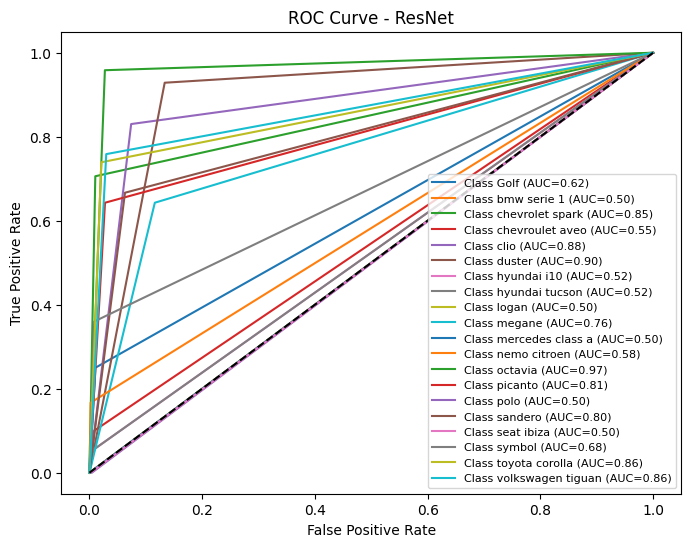

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet')
plt.legend(fontsize=8)
plt.show()
